In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import config, convert2yolov1
from src.util import video2images, get_video_folder_paths, seleccionar_imagen, merge_datasets
from src.model import autolabel_images, predict_and_visualice
from src.dataset_processing import run_processing_dataset
import os
import json
import supervision as sv
import cv2
from src.data_augmentation import augment_dataset

trying to load grounding dino directly


d:\Alexander\Go2Future\Autolabel_roboflow\.venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [56]:
# convertir los video en imagenes
# crear en el directorio raiz la ruta test\video_test\<sku del producto>
# colocar dentro un video y un archivo ontology.json con la ontología. 
video_path= get_video_folder_paths(config.VIDEO_TEST)[0]
print(video_path)

d:\Alexander\Go2Future\Autolabel_roboflow\test\video_test\7790040133488


In [57]:
# create image folder for each video folder
    
image_dir_path = os.path.join(config.IMAGE_TEST, os.path.basename(video_path))
if not os.path.exists(image_dir_path):
    os.mkdir(image_dir_path)

video2images(video_path, image_dir_path, frame_rate=200)

100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [146]:
# create dataset folder for each video folder
if not os.path.exists(config.DATA_TEST):
    os.mkdir(config.DATA_TEST)
    
dataset_dir_path = os.path.join(config.DATA_TEST, os.path.basename(video_path))
if not os.path.exists(dataset_dir_path):
    os.mkdir(dataset_dir_path)


In [147]:

autolabel_images(
            input_folder=image_dir_path,
            ontology=json.load(open(os.path.join(video_path, "ontology.json"))),
            box_threshold=0.35,
            text_threshold=0.25,
            output_folder=dataset_dir_path,
            extension=".jpg",
        )

Labeling d:\Alexander\Go2Future\Autolabel_roboflow\test\image_test\7790040133488\7790040133488_vertical_3-00005.jpg: 100%|██████████| 6/6 [02:32<00:00, 25.43s/it]


Labeled dataset created - ready for distillation.


In [151]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train","labels")
IMAGES_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train", "images")
DATA_YAML_PATH = os.path.join(dataset_dir_path, "data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

4

In [45]:
# create fuction to read a list of labels files .txt into a folder and erase empty files
# and remove images respect to the labels files

import os
def erase_empty_files(label_path, image_path):
    for lab_filename, image_filaname in zip(os.listdir(label_path), os.listdir(image_path)):
        if os.stat(os.path.join(label_path, lab_filename)).st_size == 0:
            os.remove(os.path.join(label_path, lab_filename))
            os.remove(os.path.join(image_path, image_filaname)
        )  
erase_empty_files(ANNOTATIONS_DIRECTORY_PATH ,IMAGES_DIRECTORY_PATH)    

In [150]:
run_processing_dataset(IMAGES_DIRECTORY_PATH, ANNOTATIONS_DIRECTORY_PATH, max_size=0.5, iou_threshold=0.1)


In [ ]:
# Mostrar las anotaciones realizadas por el modelo base
SAMPLE_SIZE = 4
SAMPLE_GRID_SIZE = (2, 2)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

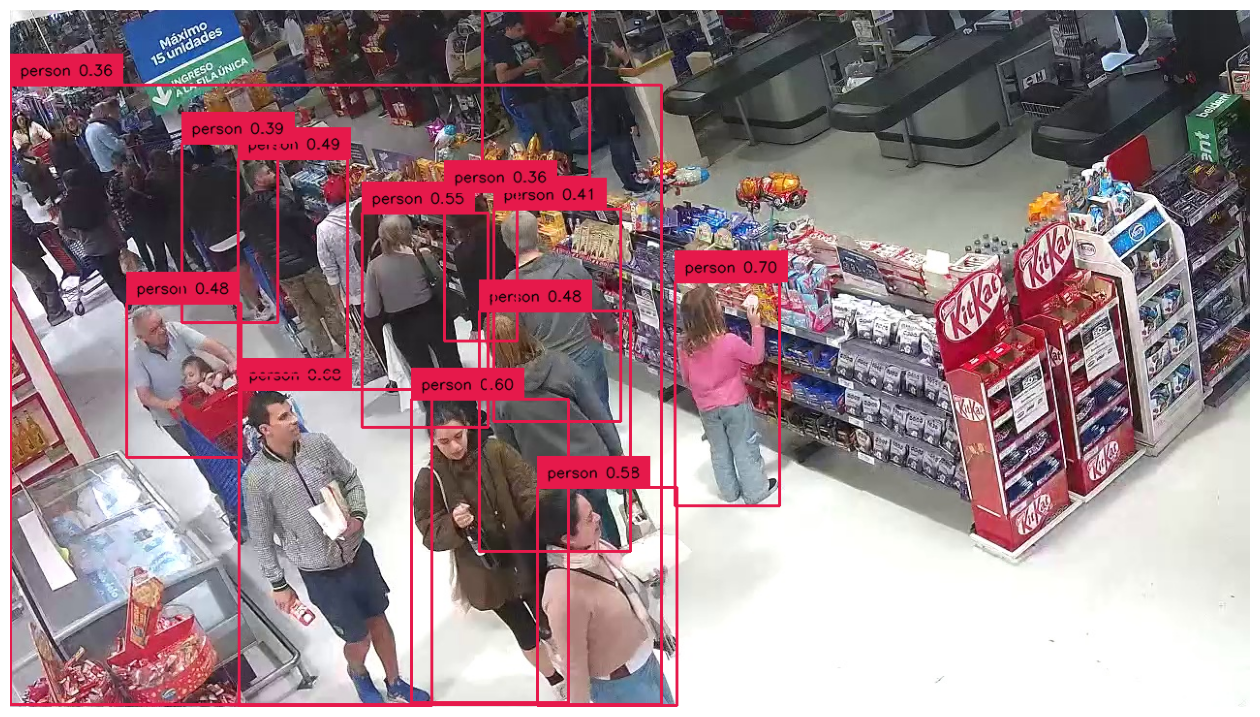

In [15]:
#image_path=os.path.join(config.IMAGE_DIR_PATH, "7790040133487/7790040133487_vertical_1-00000.jpg")
image_path=seleccionar_imagen()
predict_and_visualice(image_path, {"People": "person"}, box_threshold=0.35, text_threshold=0.25)

### Hcer merge de cada dataset individual

In [3]:
# Unir datasets
    # crear el path a la carpeta de merged dataset dentro de dataset
output_path = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
    # obtener el nombre de cada dataset individual dentro de dataset
folders = os.listdir(config.DATASET_DIR_PATH)
    # Lista de paths de cada dataset individual
dataset_paths = [os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]
    # Hacer el merge
merge_datasets(dataset_paths, output_path)

INFO:root:Merging datasets...
100%|██████████| 2/2 [00:11<00:00,  5.51s/it]
INFO:root:Merged datasets created at d:\Alexander\Go2Future\Autolabel_roboflow\dataset\Merged_Dataset


['person', 'person']
['person']


### Corregir errores de etiquetado

In [ ]:
# Procesar Merged_Dataset/train para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "train", "images"),
        os.path.join(output_path, "train", "labels"),
    )
    # Procesar Merged_Dataset/valid para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "valid", "images"),
        os.path.join(output_path, "valid", "labels"),
    )

## Llevar todas las anotaciones a un video

In [19]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/train/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/train/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

32

## Data augmentation

In [ ]:
dataset_path=os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
augmented_dataset_path=os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset")
# creating aumented datased directory
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

augment_dataset(dataset_path, augmented_dataset_path, augmented_for=5)

## Convertir a formato yolov1 para CVAT

In [8]:
# Convertir un solo dataset dentro de DATASET_DIR_PATH
dataset_path=os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
convert2yolov1.convert_to_yolov1_format(dataset_path) 


trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


In [10]:
# Convertir todos los datasets dentro de DATASET_DIR_PATH
# Directorio que contiene todos los datasets
dataset_dir_path = config.DATASET_DIR_PATH

# Iterar a través de los subdirectorios en DATASET_DIR_PATH
for dataset_name in os.listdir(dataset_dir_path):
    dataset_path = os.path.join(dataset_dir_path, dataset_name)
    
    # Verificar si el elemento en DATASET_DIR_PATH es un directorio
    if os.path.isdir(dataset_path):
        print(f"Procesando el dataset: {dataset_name}")
        convert2yolov1.convert_to_yolov1_format(dataset_path)

print("Proceso de conversión completado para todos los datasets.")

Procesando el dataset: 5-12-2023-1059
Procesando el dataset: 5-12-2023-1156
Procesando el dataset: 5-12-2023-1500
Procesando el dataset: 5-12-2023-1555
Procesando el dataset: Merged_Dataset
Proceso de conversión completado para todos los datasets.


label file is empty


In [3]:
# crear un directorio dentro de config.DATASET_DIR_PATH
yolo8_out =os.path.join(config.DATASET_DIR_PATH,"Merged_dataset")
os.makedirs(yolo8_out, exist_ok=True)

convert2yolov1.convert_to_yolov8_format(os.path.join(config.DATASET_DIR_PATH,"dataset_4_camIP_corregido.zip"),yolo8_out)

In [3]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

435

In [4]:
image_names = list(dataset.images.keys())

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

In [14]:
# Especificar la ruta del video de salida y la velocidad de fotogramas
video_name =os.path.join(config.DATASET_DIR_PATH, "anotaciones.mp4") 
fps = 2

# Obtener la altura y el ancho de la primera imagen
height, width, layers = images[0].shape

# Crear el objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

# Agregar cada imagen al video
for image in images:
    video.write(image)

# Liberar el objeto VideoWriter y cerrar la ventana
cv2.destroyAllWindows()
video.release()

## Salvar imagenes anotadas para visualización

In [5]:
# Crear una carpeta para almacenar las imágenes si no existe
anotate_images=os.path.join(config.DATASET_DIR_PATH, "imagenes_anotadas")
if not os.path.exists(anotate_images):
    os.makedirs(anotate_images)


# Guardar cada imagen como un archivo individual
for idx, image in enumerate(images):
    output_path = os.path.join(anotate_images, f"imagen_{idx+1}.png")
    cv2.imwrite(output_path, image)

print("Imágenes guardadas exitosamente.")

Imágenes guardadas exitosamente.
